
**Just how quick is quick sort?**

---
<br/>
Last time we compared different sorting methods using their speed to sort a random list of integers. We went through insertion sort, radix sort and merge sort.<br/>
This time, I want to study quick sort and stress testing it with different datasets.<br/><br/>
Judging by the name, I sometimes wonder what makes this sort different - one that characterizes itself by the speed of the algo.<br/><br/>Let's try it.

In [0]:
import time
import matplotlib.pyplot as plt
import random
import math

<br/>**QuickSort**<br/>
<br/>

Like mergesort, quicksort is a divide-and-conquer algorithm that divides an input array into smaller arrays. These two arrays, however, are not same in size, like what mergesort is. Simply put, there are a few steps: <br/><br/>1) Selecting a pivot of the items, and putting all items smaller than it to the left, and larger items to the right of pivot.<br/>2) After this step, this pivot is in the right place in respective to the array<br/>3) Go to the left part and right part, do the same thing recursively<br/><br/>
Seems that there are different versions each uses a different method to calculate pivots and partitions. The following is a simple quicksort I made, which do not rely on in-place sorting.

In [0]:
def quickSort(a_list):

  if len(a_list) <= 1:
    return a_list

  last = a_list[-1]
  left = []
  right = []
  same = [last]

  for i in range(len(a_list)-1):
    if a_list[i] < last:
      left.append(a_list[i])
    elif a_list[i] > last:
      right.append(a_list[i])
    else:
      same.append(a_list[i])
  
  return quickSort(left) + same + quickSort(right)


Using our good old tester function:

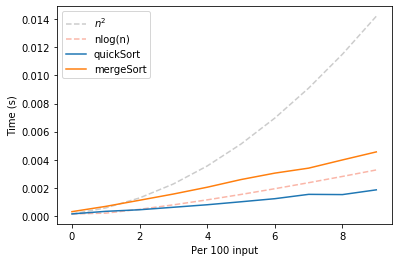

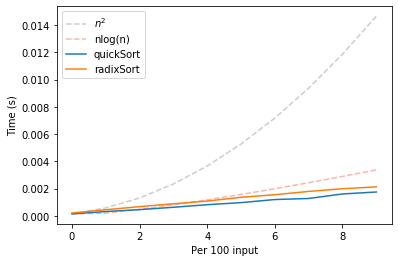

In [22]:
tester([quickSort, mergeSort])
tester([quickSort, radixSort])

Woah, the quickSort we coded in 2 mins actually beat both mergeSort and radix sort. That's quite amazing.<br/>Can we call that a win for quickSort?<br/><br/>

With a little thinking, it is easy to come to a conclusion that quickSort's worst case happens when you use the extreme as pivot every time; You are just bringing an item to the front/back without simplifying rest of the problem; In that case, it is no faster than bubble sort or insertion sort.<br/><br/>
Notice that the pivot of choice, in the above case, is always the last item. So, the worst case happens when the list is sorted, either forward or backwards. <br/>It performs really well here because the list is random - we make sure of that when we generate the numbers. But in reality, it is often not the case; Sometimes the list is nearly sorted; Sometimes it is nearly reversed. In order to arrive at a conclusion we need to do more testing.


Let's create some number generators for different situations:<br/><br/>
**SortedGen**: sorted numbers with varied intervals<br/>
**nearSorted**: Largely sorted, but 10% of the numbers are not<br/>
**notSorted**: Completely reversed<br/>
**RandGen**: random numbers<br/>

In [0]:
def sortedGen(num):
  gen = [1]
  for i in range(num - 1):
    add = random.randrange(5)
    gen.append(gen[i] + add)
  return gen

def nearSorted(num):
  gen = [1]
  for i in range(num - 1):
    if random.random() > 0.1:
      add = random.randrange(5)
    else:
      add = - min(random.randrange(10), gen[i])     # avoid getting negative number
    gen.append(gen[i] + add)
  return gen

def notSorted(num):
  gen = sortedGen(num)
  gen.reverse()
  return gen

def randGen(num):
  ceil = 5 / 2 * num
  gen = []
  for i in range(num):
    gen.append(random.randrange(ceil))
  return gen

def getAllGen(n):
  _res = sortedGen(n), nearSorted(n), notSorted(n), randGen(n)
  return _res

To give an idea of what the generated list looks like, here is a generation of 200 numbers:

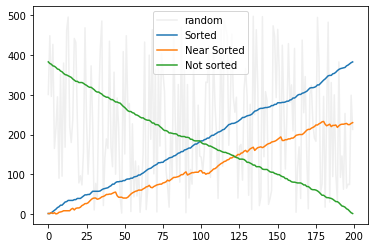

In [0]:
n = 200
line1 = sortedGen(n)
line2 = nearSorted(n)
line3 = notSorted(n)
line4 = randGen(n)

plt.plot(line4, label='random', color = "#efefef")
plt.plot(line1, label='Sorted')
plt.plot(line2, label='Near Sorted')
plt.plot(line3, label='Not sorted')
plt.legend()
plt.show()

Now the stress test function. To lessen the time, only 20 trials will be done each time, with the median taken and recorded.

In [0]:
def stressTest(functions, genFunction):

  data = []
  nlogn = []
  results = {}
  factor = 0

  for i in range(1, 11):
    _new = []
    data.append([genFunction(i * 100)])

  for func in functions:
    median = []
    count = 1
    for sets in data:
      compare = []
      for i in range(20):   # 20 times only
        thisRound = []
        for kind in sets:
          start = time.time()
          temp = func(kind)
          end = time.time()
          thisRound.append(end - start)
        compare.append(thisRound)
        transpose = list(map(list, zip(*compare)))
      median.append([sorted(l)[len(l) // 2] for l in transpose])
      count = count + 1
    median = list(map(list, zip(*median)))
    results[func.__name__] = median
    

#using the last value and divide it by 10 to make the reference line

  _maxtimeList = [results[func.__name__][i][-1] for i in range(len([genFunction(2)]))]
  mean = sum(_maxtimeList) / len(_maxtimeList) / 10
  nlogn = [mean]
  factor = 100 * math.log(100) / mean
  for i in range(2,10):
    nlogn.append(i*100 * math.log(i*100) / factor)
  plt.plot(nlogn, '--', label='nlog(n)', color = '#cccccc')

  for func in functions:
    for i in range(len([genFunction(2)])):
      plt.plot(results[func.__name__][i], label = func.__name__)


  plt.xlabel('Per 100 input')
  plt.ylabel('Time (s)')
  plt.title(genFunction.__name__)
  plt.legend()
  plt.show()

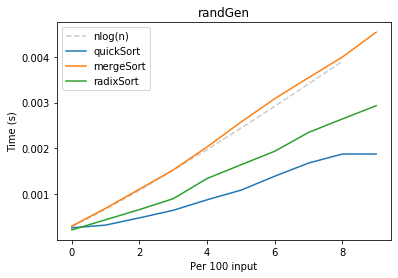

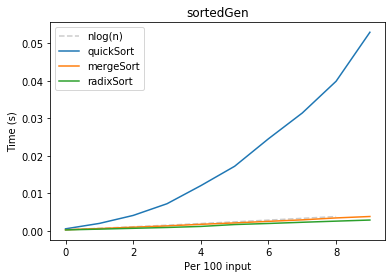

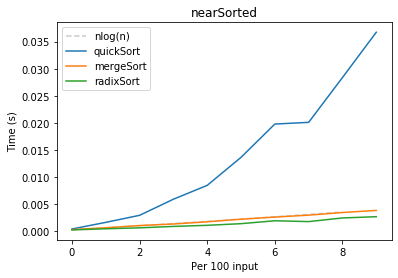

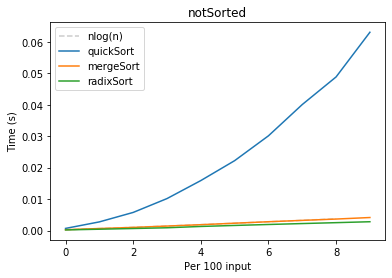

In [26]:
stressTest([quickSort, mergeSort, radixSort], randGen)
stressTest([quickSort, mergeSort, radixSort], sortedGen)
stressTest([quickSort, mergeSort, radixSort], nearSorted)
stressTest([quickSort, mergeSort, radixSort], notSorted)

We kind of expected this... quickSort is a king when sorting random numbers, but definitely struggle on data that is already structured, resembling the **n^2** line in both sorted and reversed cases. In both cases, it performed significantly worse than mergeSort and radixSort, which means that this implementation is not good to use as a general all-purpose sorter...<br/><br/>Judging by the data above, I will choose mergeSort over quickSort any day...<br/>
Can we improve it?

**Choice of pivot**<br/><br/>
The choice of pivot is definitely a factor leading to the run time. Normally, it is suggested to use the last element as the pivot. But you can actually make an estimation of the pivot choice to provide a better run time.<br/>
Robert Sedgewick in his textbook recommends using the median between the start, the middle and the end as the pivot of choice.<br/><br/>
On paper, by using a constant time to locate a median of the three ends, it should help in cases of sorted and reversed arrays.<br/><br/>
Lets see how it will help.

In [0]:
#Quick Sort according to Sedgewick

def quickSortS(a_list):

  length = len(a_list)
  if length <= 1:
    return a_list

  #choosing a pivot
  choices = [a_list[0], a_list[-1], a_list[length // 2]]
  piv = sorted(choices)[1]

  left = []
  right = []
  same = []

  for i in range(len(a_list)):
    if a_list[i] < piv:
      left.append(a_list[i])
    elif a_list[i] > piv:
      right.append(a_list[i])
    else:
      same.append(a_list[i])
  
  return quickSortS(left) + same + quickSortS(right)


In [44]:
_l = [86, 53, 94, 67, 42, 6, 8, 10, 2, 5, 7]
quickSortS(_l)

[2, 5, 6, 7, 8, 10, 42, 53, 67, 86, 94]

Now it's working, lets put it side by side with our original quickSort:

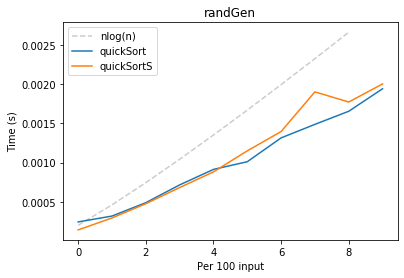

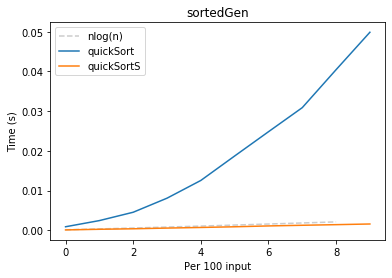

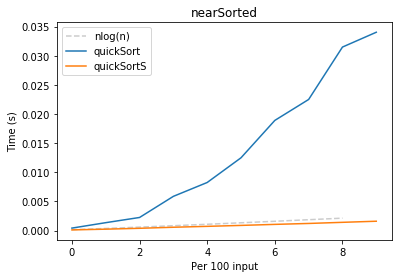

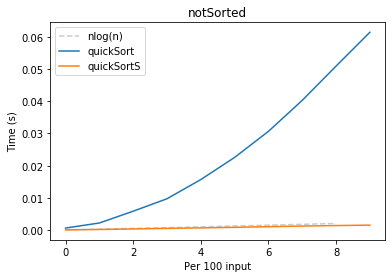

In [45]:
stressTest([quickSort, quickSortS], randGen)
stressTest([quickSort, quickSortS], sortedGen)
stressTest([quickSort, quickSortS], nearSorted)
stressTest([quickSort, quickSortS], notSorted)

That's quite an improvement here.<br/>As demonstrated, it definitely help a lot to do a bit pre-processing up front to choose a pivot wisely. In the previously worst cases, the runtime is cut to a fraction of the time needed.<br/><br/>
Will it beat the others?

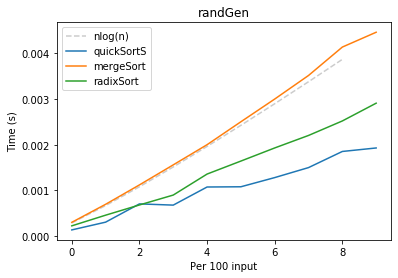

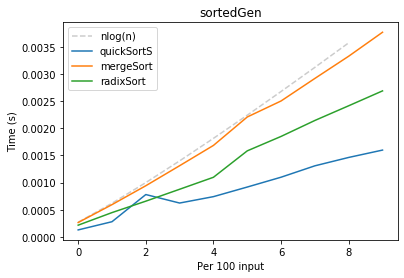

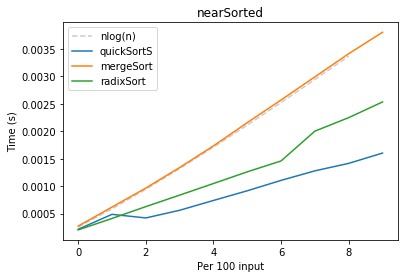

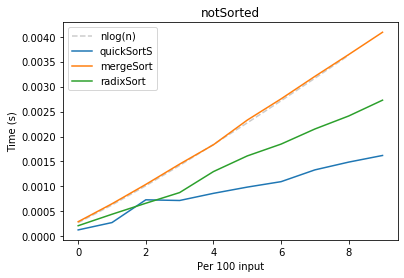

In [71]:
stressTest([quickSortS, mergeSort, radixSort], randGen)
stressTest([quickSortS, mergeSort, radixSort], sortedGen)
stressTest([quickSortS, mergeSort, radixSort], nearSorted)
stressTest([quickSortS, mergeSort, radixSort], notSorted)

Dang that's quick!<br/>
Quite sure quick sort takes our new crown here, as it shows a better performance consistently than other sorting methods we have.<br/><br/><br/><br/>

**BONUS THOUGHT**<br/><br/>
One would wonder that, we achieve quite a significant improvement by choosing a median of three points as the pivot. Now we know it optimizes a lot,  why don't we choose a median of more points? Let's choose a median of 5, 7, 9 points of the array and make quickSort even quicker!

In [0]:
#statistics for median finding
import statistics

# n-point median pivot
def quickSortN(n, a_list):

  length = len(a_list)
  if length <= 1:
    return a_list

  #make the list
  choices = []
  if len(a_list) <= n:
    choices = a_list
  else:
    for i in range(0, length, max(1, length // (n-1))):
      choices.append(a_list[i])

  #choosing the pivot
  piv = int(statistics.median(choices))

  left = []
  right = []
  same = []

  for i in range(len(a_list)):
    if a_list[i] < piv:
      left.append(a_list[i])
    elif a_list[i] > piv:
      right.append(a_list[i])
    else:
      same.append(a_list[i])
  
  return quickSortN(n, left) + same + quickSortN(n, right)

#quickSort with pivot of 5-point median
def quickSortV(a_list):
  return quickSortN(5, a_list)

#quickSort with pivot of 7-point median
def quickSortVII(a_list):
  return quickSortN(7, a_list)

#quickSort with pivot of 9-point median
def quickSortIX(a_list):
  return quickSortN(9, a_list)
  

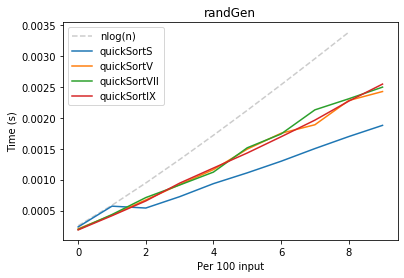

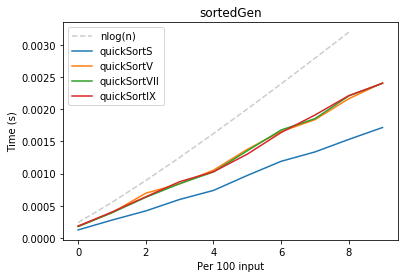

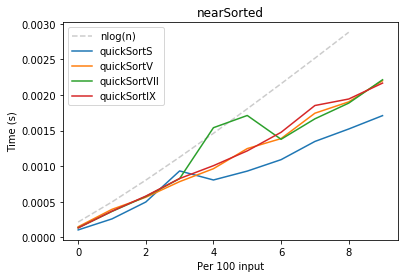

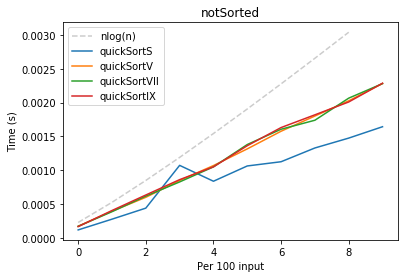

In [74]:
stressTest([quickSortS, quickSortV, quickSortVII, quickSortIX], randGen)
stressTest([quickSortS, quickSortV, quickSortVII, quickSortIX], sortedGen)
stressTest([quickSortS, quickSortV, quickSortVII, quickSortIX], nearSorted)
stressTest([quickSortS, quickSortV, quickSortVII, quickSortIX], notSorted)

<br/>It seems that, although using a pivot that's closer to the real median could yield a better performance theoratically, **there's an additional overhead in computing an n-point median**. In the dataset that we have, since median is usually located somewhere in the middle (refer to the number generation chart above), this additional computation overhead does not make an n-point median a better choice.<br/>
Since the difference is too little to call a win, let's say that this optimization could be useful, but it depends on how sparse your dataset is.

<br/>**Appendix: Sorting in place with typical partition**

In [0]:

def partition(a_list, s, e):

  last = e
  e -= 1
  while s <= e:
    if a_list[s] >= a_list[last]:
      a_list[s], a_list[e] = a_list[e], a_list[s]
      e -= 1
    else:
      s += 1

  if e + 1 != last:
    a_list.insert(e+1, a_list[last])
    del a_list[last+1]
  return e + 1


def quickSortP(a_list, s, e):
  if len(a_list) <= 1 or e <= s:
    return a_list
  else:
    i = partition(a_list, s, e)
    if i > s + 1:
      quickSortP(a_list, s, i - 1)
    if i < e - 1:
      quickSortP(a_list, i + 1, e)
    return a_list

def quickSortbyP(a_list):
  return quickSortP(a_list, 0, len(a_list)-1)